# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
x = datasets.MNIST('data', download=True)
x[0]

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



87.4%

100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(<PIL.Image.Image image mode=L size=28x28>, 5)

In [3]:
x[0][0]

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [5]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [6]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

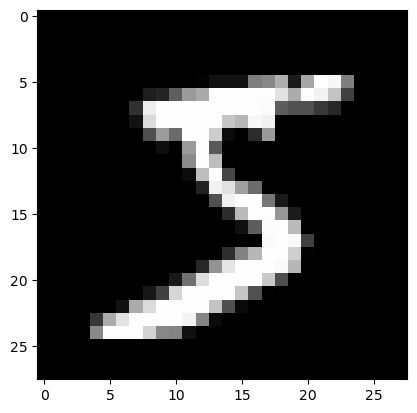

In [8]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

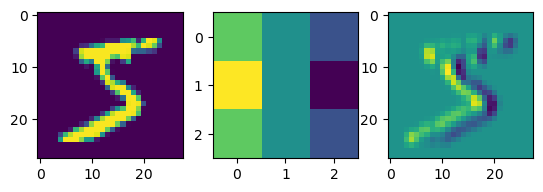

In [9]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [12]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [13]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

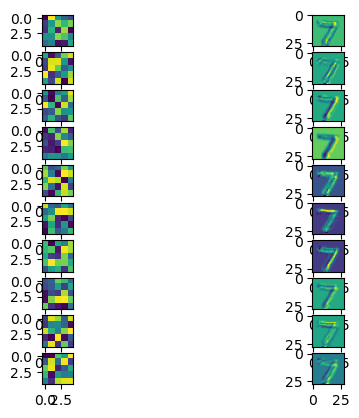

In [14]:
visualize()

# Predict Using Network

In [15]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [16]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([1, 8, 3, 8, 5])

# First Test and Train

In [17]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [18]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 7%



In [19]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [20]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.331096
Train loss: 2.020869
Train loss: 1.260964
Train loss: 0.887578
Train loss: 0.726092
Train loss: 0.879925
Train loss: 0.592217
Train loss: 0.604264
Train loss: 0.457922
Train loss: 0.681168


# Train Network

In [21]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.360767
Train loss: 1.936624
Train loss: 1.171179
Train loss: 0.870675
Train loss: 0.583516
Train loss: 0.667334
Train loss: 0.634565
Train loss: 0.576151
Train loss: 0.514600
Train loss: 0.825756
Test accuracy: 94%

Train loss: 0.453506
Train loss: 0.400389
Train loss: 0.341786
Train loss: 0.834626
Train loss: 0.222548
Train loss: 0.498675
Train loss: 0.259486
Train loss: 0.373039
Train loss: 0.559549
Train loss: 0.358427
Test accuracy: 96%

Train loss: 0.247224
Train loss: 0.229595
Train loss: 0.348942
Train loss: 0.470379
Train loss: 0.251779
Train loss: 0.255460
Train loss: 0.218069
Train loss: 0.414299
Train loss: 0.569049
Train loss: 0.489851
Test accuracy: 97%

Train loss: 0.135183
Train loss: 0.279412
Train loss: 0.412023
Train loss: 0.324061
Train loss: 0.186969
Train loss: 0.274124
Train loss: 0.232471
Train loss: 0.326895
Train loss: 0.271163
Train loss: 0.261852
Test accuracy: 97%

Train loss: 0.251508
Train loss: 0.180368
Train loss: 0.236364
Train loss: 0.231

# Inspect Network

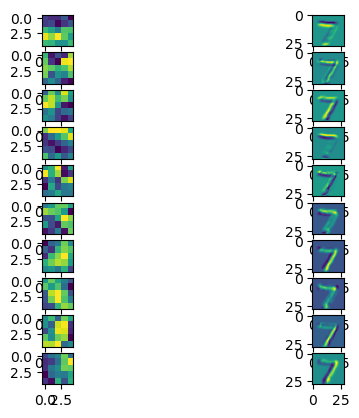

In [22]:
visualize()

In [23]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [24]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [51]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [52]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.305392
Train loss: 1.796324
Train loss: 1.099974
Train loss: 0.965082
Train loss: 0.752897
Train loss: 0.735149
Train loss: 0.701009
Train loss: 0.579330
Train loss: 0.509751
Train loss: 0.608385
Test accuracy: 94%

Train loss: 0.439394
Train loss: 0.418899
Train loss: 0.346920
Train loss: 0.596391
Train loss: 0.360613
Train loss: 0.542353
Train loss: 0.276509
Train loss: 0.426585
Train loss: 0.434832
Train loss: 0.329176
Test accuracy: 96%

Train loss: 0.345425
Train loss: 0.423977
Train loss: 0.271890
Train loss: 0.301247
Train loss: 0.184863
Train loss: 0.287168
Train loss: 0.259135
Train loss: 0.216447
Train loss: 0.220940
Train loss: 0.303014
Test accuracy: 97%

Train loss: 0.172560
Train loss: 0.310459
Train loss: 0.343816
Train loss: 0.328122
Train loss: 0.160101
Train loss: 0.446786
Train loss: 0.272152
Train loss: 0.285736
Train loss: 0.303615
Train loss: 0.303753
Test accuracy: 97%

Train loss: 0.118151
Train loss: 0.203116
Train loss: 0.255208
Train loss: 0.275

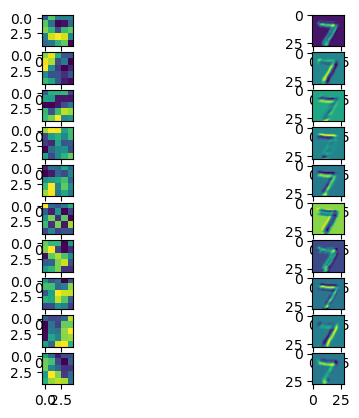

In [53]:
visualize()

In [54]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [55]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.341118
Train loss: 2.139990
Train loss: 1.512621
Train loss: 0.778794
Train loss: 0.710495
Test accuracy: 91%

Train loss: 0.811052
Train loss: 0.654122
Train loss: 0.469854
Train loss: 0.465941
Train loss: 0.443588
Test accuracy: 95%

Train loss: 0.354776
Train loss: 0.412941
Train loss: 0.285631
Train loss: 0.402310
Train loss: 0.348557
Test accuracy: 96%

Train loss: 0.248644
Train loss: 0.452457
Train loss: 0.245738
Train loss: 0.369854
Train loss: 0.294077
Test accuracy: 97%

Train loss: 0.390946
Train loss: 0.238239
Train loss: 0.299609
Train loss: 0.362971
Train loss: 0.211142
Test accuracy: 97%



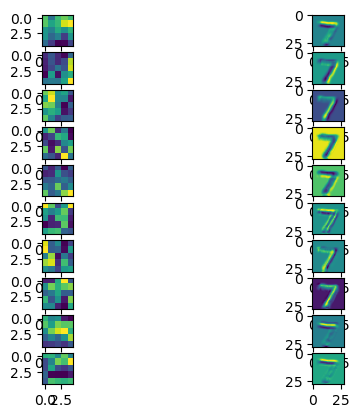

In [56]:
visualize()

In [57]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [58]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.292856
Test accuracy: 35%

Train loss: 2.137726
Test accuracy: 79%

Train loss: 1.330878
Test accuracy: 85%

Train loss: 0.990228
Test accuracy: 89%

Train loss: 0.934320
Test accuracy: 90%



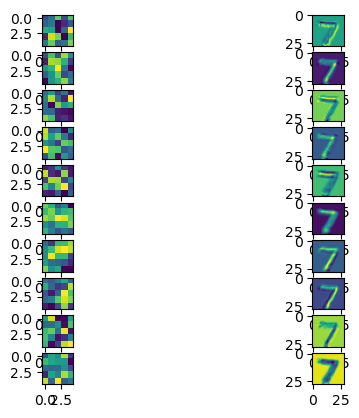

In [59]:
visualize()

In [60]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [61]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.358921
Test accuracy: 27%

Train loss: 2.238597
Test accuracy: 59%

Train loss: 2.040175
Test accuracy: 70%

Train loss: 1.640409
Test accuracy: 80%

Train loss: 1.450762
Test accuracy: 83%



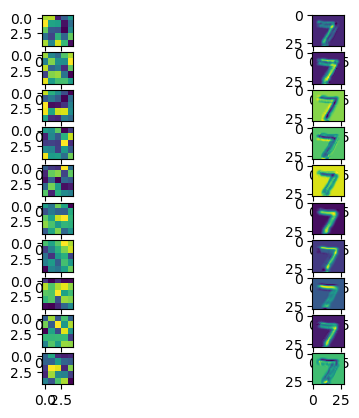

In [62]:
visualize()

In [63]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [64]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_56606/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.363266
Test accuracy: 21%

Train loss: 2.284748
Test accuracy: 23%

Train loss: 2.255141
Test accuracy: 25%

Train loss: 2.238695
Test accuracy: 34%

Train loss: 2.220432
Test accuracy: 35%



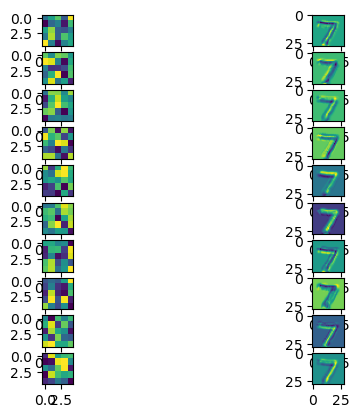

In [65]:
visualize()

# Question 1a

#### Overall, as the number of training images increases, the accuracy of the system increases. More training images allows for more training loops, which gives the system more opportunity to improve its accuracy.

- After training with 60,000 images, the accuracy improved from 94% to 98% over the course of the five epochs run.
- After training with 30,000 images, the accuracy improved from 91% to 97% over the course of the five epochs run.
- After training with 6,000 images, the accuracy improved from 35% to 90% over the course of the five epochs run.
- After training with 3,000 images, the accuracy improved from 27% to 83% over the course of the five epochs run.
- After training with 600 images, the accuracy improved from 21% to 35% over the course of the five epochs run.

# Question 1b

#### The weights appear much more randomized and scattered when trained with 600 images vs 60,000